# Swamp hunting <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI` environment
* **Products used:** 
[fc_percentile_albers_annual](https://explorer.sandbox.dea.ga.gov.au/fc_percentile_albers_annual)

## Description

Let's pretend I want to find precisely and only palustrine wetlands. I'm talking your classic swamps: vegetated, not a river, not a lake, usually wet, usually green. How would I do this given the products we have at our disposal?

Queensland (QLD) has extremely detailed [wetland mapping](https://wetlandinfo.des.qld.gov.au/wetlandmaps/). Let's try to find all the really swampy stuff in Queensland using these wetlands as a guide.

## Getting started

Run `Wetland_pixel_visualisation.ipynb` to get ahold of an even sample of wetlands and non-wetlands in 25 QLD tiles. Then...

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%%bash
pip install rioxarray

Defaulting to user installation because normal site-packages is not writeable


Unload all python modules, if you experience any issues.


In [336]:
%matplotlib inline

import functools
from multiprocessing.pool import Pool
import multiprocessing
import os
import sys
import cmocean
import datacube
from datacube.storage.masking import make_mask
import datacube.utils.cog
import datacube.utils.geometry
import geopandas as gpd
import ipyleaflet
from IPython.display import display
import ipywidgets as widgets
import matplotlib.colors
import matplotlib.patches
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import odc.ui
from odc.ui import with_ui_cbk
import rasterio.features
import rasterio.mask
import rioxarray
import scipy.stats
import seaborn
from shapely.geometry import shape, point
from shapely.validation import explain_validity
import skimage.color as colour
import skimage.io
import sklearn.decomposition
import sklearn.metrics
import sklearn.pipeline
import sklearn.preprocessing
from tqdm.notebook import tqdm
import xarray

sys.path.append("../Scripts")
from dea_plotting import rgb
from dea_dask import create_local_dask_cluster

### Set up Dask

This will let us lazily load tiles.

In [3]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:46428 Dashboard: /proxy/8787/status,Cluster Workers: 1 Cores: 8 Memory: 30.67 GB


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [4]:
dc = datacube.Datacube(app="swamp-hunting")

### Load wetland shapes

The wetlands shapefile contains all wetlands in QLD.

In [5]:
wetlands = gpd.read_file(
    "QSC_Extracted_Data_20200820_104013993000-3580/Wetland_areas.shp"
)

In [6]:
len(wetlands)

534519

In [7]:
wetlands = wetlands.to_crs('EPSG:3577')

In [8]:
wetlands = wetlands[wetlands.WETCLASS_.notnull()]

We only have TCG for 25 tiles, so load those tiles:

In [9]:
tiles = gpd.read_file("QLDTestTiles.shp")

Then strip down the wetlands to only include shapes we have data for.

In [10]:
# buffer(0) attempts to correct invalid geometries.
sampled_wetlands = wetlands.to_crs('EPSG:3577').buffer(0).geometry.intersection(tiles.unary_union)

In [11]:
wetlands = wetlands[~sampled_wetlands.is_empty].reset_index()

In [12]:
len(wetlands)

94379

### Load data functions

These functions access TCW, TCG, wetland, MrVBF, and Koppen data on a per-tile basis.

In [84]:
def get_tcw(tile_label):
    tif_path_base = "/g/data/r78/datacube_stats/TCW_stats/demo_tiles/output_qld_wetness/LS_TCW_PC_{}_1986_2020_summary.tif"
    tif_path = tif_path_base.format(tile_label.replace(",", "_"))
    da = xarray.open_rasterio(tif_path, chunks={'band': 1, 'x': 1024, 'y': 1024})
    return da


def get_tcg(tile_label):
    tif_path_base = "/g/data/r78/datacube_stats/TCW_stats/demo_tiles/output_qld_greenness/LS_TCG_PC_{}_1986_2020_summary.tif"
    tif_path = tif_path_base.format(tile_label.replace(",", "_"))
    da = xarray.open_rasterio(tif_path, chunks={'band': 1, 'x': 1024, 'y': 1024})
    return da


def get_mrvbf(tile_label):
    mrvbf_path_base = (
        mrvbf_base_path
    ) = "/g/data/u46/wofs/confidence_albers/MrVBF/tiles/mrvbf_{}.nc"
    mrvbf_path = mrvbf_path_base.format(tile_label.replace(",", "_"))
    da = xarray.open_dataset(mrvbf_path, chunks={'time': 1, 'x': 1024, 'y': 1024}).band1
    da.attrs['crs'] = 'EPSG:3577'
    return da


def get_koppen_tile(da):
    koppen = rasterio.open(
        "/g/data/r78/ma6611/Beck_KG_V1_present_0p0083.tif"
    )  # 1km resolution
    dest = np.zeros(da.shape)
    src_transform = koppen.transform
    koppen_tile = rasterio.warp.reproject(
        koppen.read(),
        dest,
        src_crs=koppen.crs,
        dst_crs="EPSG:3577",
        src_transform=src_transform,
        dst_transform=da.transform,
    )
    kop = xarray.DataArray(koppen_tile[0].astype(int), coords=da.coords)
    kop.attrs['crs'] = da.crs
    return kop

Let's lazily load all the tiles.

In [85]:
tcws = {tile.label: get_tcw(tile.label) for tile in tiles.itertuples()}
tcgs = {tile.label: get_tcg(tile.label) for tile in tiles.itertuples()}

In [86]:
vbfs = {tile.label: get_mrvbf(tile.label) for tile in tiles.itertuples()}

In [79]:
kops = {tile: get_koppen_tile(tcw.isel(band=0)) for tile, tcw in tcws.items()}

In [15]:
joined = gpd.sjoin(wetlands, tiles, op='within')

In [16]:
wetlands = joined

## What swamps do we want?

If we're going to home in and be super precise, let's focus on just one kind of swamp. The QLD wetland data provides a "habitat" key which describes the kind of wetland in question. Let's see what there are for palustrine wetlands:

In [17]:
wetlands[wetlands.WETCLASS_ == 'Palustrine'].HAB_.unique()

array(['Coastal/ Sub-coastal floodplain grass, sedge and herb swamps',
       'Coastal/ Sub-coastal floodplain tree swamps (Melaleuca and Eucalypt)',
       'Coastal/ Sub-Coastal saline swamps',
       'Coastal/ Sub-Coastal non-floodplain tree swamps (Melaleuca and Eucalypt)',
       'Coastal/ Sub-coastal non-floodplain grass, sedge and herb swamps',
       'Coastal/ Sub-Coastal non-floodplain wet heath swamps',
       'Artificial/ highly modified wetlands (dams, ring tanks, irrigation channel',
       'Coastal/ Sub-Coastal floodplain wet heath swamps',
       'Coastal/ Sub-Coastal non-floodplain (spring) swamps',
       'Arid/ Semi-arid floodplain tree swamps',
       'Arid/ Semi-arid floodplain lignum swamps',
       'Arid/ Semi-arid floodplain grass, sedge, herb swamps',
       'Arid/ Semi-arid non-floodplain grass, sedge, herb swamps',
       'Arid/ Semi-arid non-floodplain tree swamps',
       'Arid/ Semi-arid saline swamps',
       'Arid/ Semi-arid non-floodplain lignum swamps',


Focusing on just one of these subclasses might be the way to go. Let's look at "Coastal/ Sub-coastal floodplain grass, sedge and herb swamps" (i.e. 4c) for now, as these don't seem to be getting picked up by the TCW/TCG cuts we've been using elsewhere.

In [18]:
hab_codes = dict(zip(wetlands.HAB.unique(), wetlands.HAB_.unique()))

In [19]:
focus_code = '4c'

In [20]:
focus_wetlands = wetlands[wetlands.HAB == focus_code]

In [21]:
len(focus_wetlands)

8019

There are about 8000 of these wetlands in our tiles. Let's look at a few.

In [231]:
def plot_wetland(wetland):
    bbox = wetland.geometry.buffer(200).envelope
    
    tcw = tcws[wetland.label].rio.clip([bbox])
    tcg = tcgs[wetland.label].rio.clip([bbox])
    vbf = vbfs[wetland.label].rio.clip([bbox])

    rgb_ = dc.load('ls8_nbart_geomedian_annual', time='2019-01', geopolygon=datacube.utils.geometry.Geometry(bbox, crs='EPSG:3577'))

    fig = plt.figure(figsize=(15, 5))

    ax1 = fig.add_subplot(1, 3, 1)
    bands = tcw.isel(band=[0, 1, 2]).astype(float)  # blue > green > red
    bands = bands - bands.min(dim=('x', 'y'))
    bands = bands / bands.max(dim=('x', 'y'))
    bands.plot.imshow(ax=ax1)

    ax2 = fig.add_subplot(1, 3, 2)
    bands = tcg.isel(band=[0, 1, 2]).astype(float)
    bands = bands - bands.min(dim=('x', 'y'))
    bands = bands / bands.max(dim=('x', 'y'))
    bands.plot.imshow(ax=ax2)
    
    ax3 = fig.add_subplot(1, 3, 3)
    rgb(rgb_, bands=['red', 'green', 'blue'], ax=ax3)

    visible = focus_wetlands[focus_wetlands.within(bbox)]
    for ax in [ax1, ax2, ax3]:
        visible.plot(ax=ax, edgecolor='white', facecolor='None')
    plt.tight_layout()
    
    plt.show()

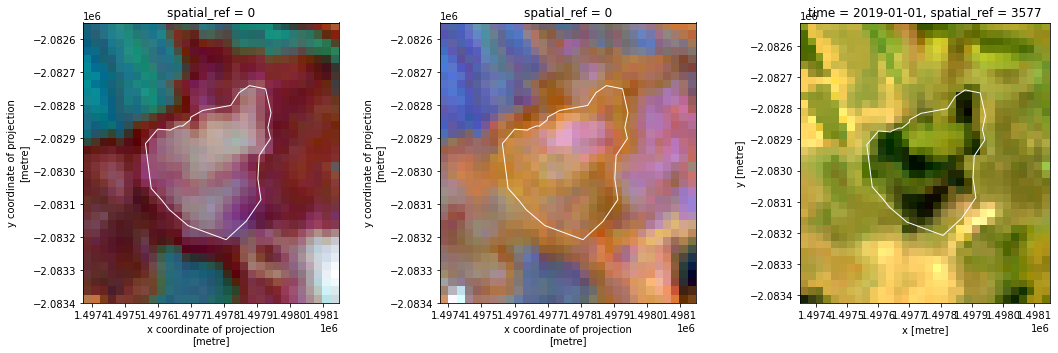

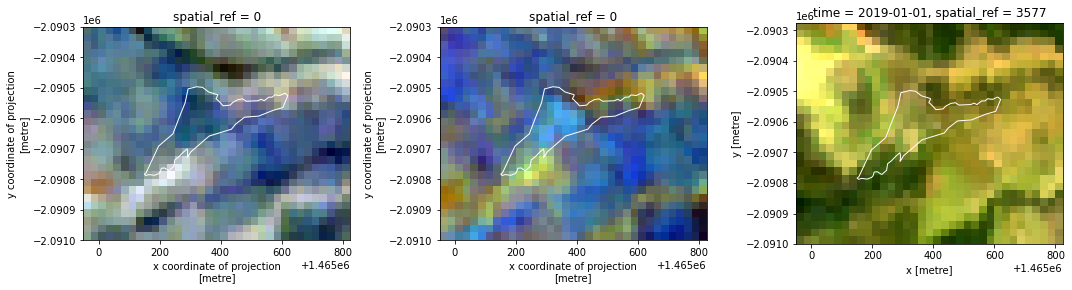

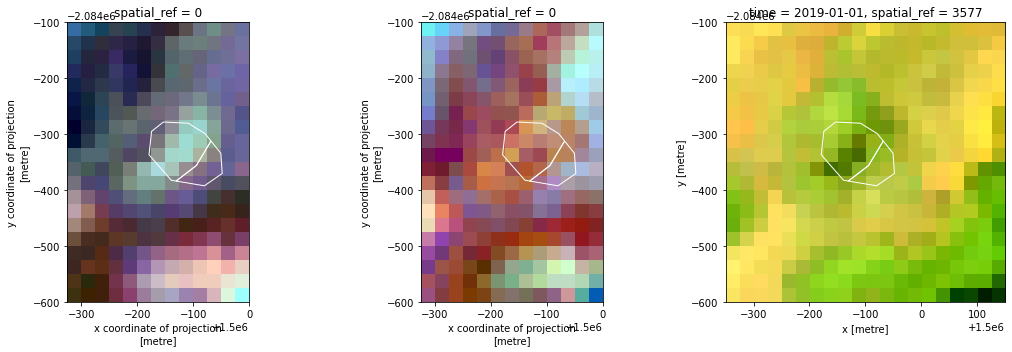

In [233]:
for i in np.arange(0, 30, 10):
    w = focus_wetlands[focus_wetlands.label == '14,-21'].iloc[i]
    plot_wetland(w)

Let's grab some pixel info for these swamps and their surrounds:

- Landsat reflectance, 
- TCW,
- TCG,
- FC.

In [235]:
geom_in = focus_wetlands.geometry.unary_union
geom_out = geom_in.buffer(200).difference(geom_in)

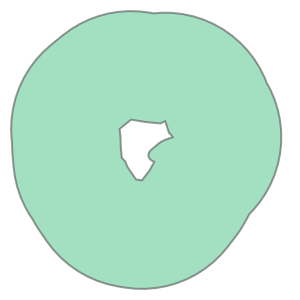

In [266]:
geom_out.geoms[0]

In [267]:
tcw_in = tcws[focus_wetlands.label[0]].rio.clip(geom_in)
tcw_out = tcws[focus_wetlands.label[0]].rio.clip(geom_out)
tcg_in = tcgs[focus_wetlands.label[0]].rio.clip(geom_in)
tcg_out = tcgs[focus_wetlands.label[0]].rio.clip(geom_out)
vbf_in = vbfs[focus_wetlands.label[0]].rio.clip(geom_in)
vbf_out = vbfs[focus_wetlands.label[0]].rio.clip(geom_out)
kop_in = kops[focus_wetlands.label[0]].rio.clip(geom_in)
kop_out = kops[focus_wetlands.label[0]].rio.clip(geom_out)

0    POLYGON ((1000000.000 -1400000.000, 1100000.00...
Name: geometry, dtype: geometry

In [299]:
ls8 = dc.load('ls8_nbart_geomedian_annual', time='2019-01',
              geopolygon=datacube.utils.geometry.Geometry(tiles[tiles.label == focus_wetlands.iloc[0].label].geometry[0], crs='EPSG:3577')).isel(time=0)

In [301]:
ls8_in = ls8.rio.clip(geom_in)
ls8_out = ls8.rio.clip(geom_out)

In [300]:
fc = dc.load('ls8_fc_albers', time='2019-01',
             geopolygon=datacube.utils.geometry.Geometry(tiles[tiles.label == focus_wetlands.iloc[0].label].geometry[0], crs='EPSG:3577')).isel(time=0)

In [302]:
fc_in = fc.rio.clip(geom_in)
fc_out = fc.rio.clip(geom_out)

We can turn these into features and try to visualise the feature space.

In [427]:
null_mask = tcw_in.values[0] <= -9999
features_in = np.concatenate([
    tcw_in.values[:, ~null_mask],
    tcg_in.values[:, ~null_mask],
    vbf_in.values[:, ~null_mask],
#     kop_in.values[None, ~null_mask],
    [ls8_in.swir2.values[~null_mask],
     ls8_in.swir1.values[~null_mask],
     ls8_in.nir.values[~null_mask],
     ls8_in.red.values[~null_mask],
     ls8_in.green.values[~null_mask],
     ls8_in.blue.values[~null_mask]],
    [fc_in.BS.values[~null_mask],
     fc_in.PV.values[~null_mask],
     fc_in.NPV.values[~null_mask],
     fc_in.UE.values[~null_mask]],
], axis=0).T

In [428]:
null_mask = tcw_out.values[0] <= -9999
features_out = np.concatenate([
    tcw_out.values[:, ~null_mask],
    tcg_out.values[:, ~null_mask],
    vbf_out.values[:, ~null_mask],
#     kop_out.values[None, ~null_mask],
    [ls8_out.swir2.values[~null_mask],
     ls8_out.swir1.values[~null_mask],
     ls8_out.nir.values[~null_mask],
     ls8_out.red.values[~null_mask],
     ls8_out.green.values[~null_mask],
     ls8_out.blue.values[~null_mask]],
    [fc_out.BS.values[~null_mask],
     fc_out.PV.values[~null_mask],
     fc_out.NPV.values[~null_mask],
     fc_out.UE.values[~null_mask]],
], axis=0).T

In [429]:
features_in = np.nan_to_num(features_in, nan=-1)  # The NaNs are only in MrVBF, which has a minimum of 0.

In [430]:
features_out = np.nan_to_num(features_out, nan=-1)

In [431]:
features_all = np.concatenate([features_in, features_out])

The most obvious thing to do is PCA.

In [432]:
pca = sklearn.decomposition.PCA(n_components=2)

In [433]:
scaler = sklearn.preprocessing.StandardScaler()

In [434]:
pipeline = sklearn.pipeline.Pipeline([('scaler', scaler), ('pca', pca)])

In [435]:
pipeline.fit(features_all[::100])

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2))])

In [436]:
pca_f_in = pipeline.transform(features_in)

In [437]:
pca_f_out = pipeline.transform(features_out)

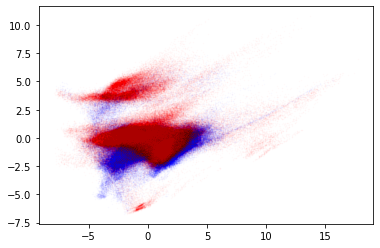

In [438]:
plt.scatter(*pca_f_in.T, s=1, c='blue', alpha=0.01)
plt.scatter(*pca_f_out.T, s=1, c='red', alpha=0.01)

There is a lot of overlap, though some separation should be possible in this plane.

Let's try a linear model.

In [464]:
import sklearn.ensemble

In [465]:
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=10, max_depth=5)

In [466]:
labels = np.zeros(len(features_all), dtype=bool)
labels[:len(features_in)] = 1

In [467]:
clf.fit(scaler.transform(features_all[::10]), labels[::10])

RandomForestClassifier(max_depth=5, n_estimators=10)

In [468]:
predictions = clf.predict(scaler.transform(features_all))

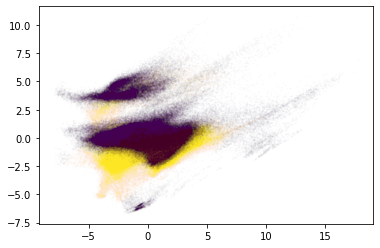

In [469]:
plt.scatter(*pipeline.transform(features_all).T, s=1, c=predictions, alpha=0.01)

<BarContainer object of 19 artists>

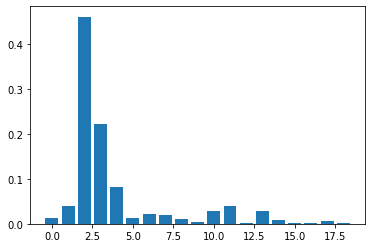

In [470]:
plt.bar(range(features_all.shape[1]), clf.feature_importances_.ravel())

Let's try running this on a tile.

In [ ]:
features_test = np.concatenate([tcws['14,-21'].values[:, :, :],
    tcgs['14,-21'].values[:, :, :],
    vbfs['14,-21'].values[:, :, :],
    # kops['14,-21'].values[None, :, :],
    [ls8.swir2.values,
     ls8.swir1.values,
     ls8.nir.values,
     ls8.red.values,
     ls8.green.values,
     ls8.blue.values],
    [fc.BS.values,
     fc.PV.values,
     fc.NPV.values,
     fc.UE.values]])

In [ ]:
features_test.shape

In [451]:
%reset Out

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


Flushing output cache (0 entries)


In [ ]:
probs = clf.predict_proba(scaler.transform(np.nan_to_num(features_test.reshape(19, -1).T, nan=-1)))

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
xarray.DataArray((probs[:, 1] > 0.5).reshape(4000, 4000), coords=tcws['14,-21'].isel(band=0).coords).plot.imshow(interpolation='gaussian', ax=ax, add_colorbar=False)
focus_wetlands[focus_wetlands.label == '14,-21'].plot(ax=ax, facecolor='None', edgecolor='white')